<H1>Prep Model</H1>

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import FlowCal as fcs
import os
from scipy.stats import gaussian_kde
import shutil
import warnings


data_dir = "data/"
for rep_dir in os.listdir(data_dir):
    rep_dir_path = os.path.join(data_dir, rep_dir)
    if not os.path.isdir(rep_dir_path):
        continue    
    if not rep_dir.startswith("replicate"):
        continue
    
    for const_dir in os.listdir(rep_dir_path):
        const_dir_path = os.path.join(rep_dir_path, const_dir)
        if not os.path.isdir(const_dir_path):
            continue   

        target_dir = os.path.join(data_dir, const_dir, rep_dir)
        os.makedirs(target_dir, exist_ok=True)
        for file in os.listdir(const_dir_path):
            file_path = os.path.join(const_dir_path, file)
            if not os.path.isfile(file_path):
                continue

            target_file_path = os.path.join(target_dir, file)
            shutil.copyfile(file_path, target_file_path)
            print(f"Copied {file_path} to {target_file_path}")

data_dir_constitutive = "data/constitutive/"
data_dir_inputs = "data/inputs/"
data_dir_gates = "data/gates/"
data_dir_reference = "data/reference/"
data_dir_basal = "data/basal/"
data_dir_inputs_cross_reactivity = "data/inputs_cross_reactivity/"

figure_dir = "figures/"
figure_extension = ".pdf"

os.makedirs(figure_dir, exist_ok=True)

reference_promoter = "J23101"                                           # The constitutive reference promoter which serves as baseline for the RPU conversion
alternative_reference_promoter_name = {"J23101": "pJCM434"}             # Currently, the reference promoter is part of the dataset in two different names
inducer_units = {"ind1": "pgul", "ind2": "uM", "ind3": "uM"}
inducer_molecule_type = {"pJCM435": "IPTG", "pJCM448": "Ara", "pJCM449": "aTc"}
controlling_input_sensor = "pJCM435"                                    # The input sensor used for the characterization of the gate plasmids
facs_channel = "FL1-A"                                                  # The fluorescence FACS channel we are interested in
p_gating = 0.95                                                         # The probability mass to preserve after gating
gating_channels = ["FSC-A", "FSC-H"]                                    # The two channels to apply gating on
kde_bandwith = 0.05


n_walkers = 10
n_chains = 10
n_samples = 10000


lim = (10**(-3), 10**2)
histogram_bins = np.logspace(np.log10(lim[0]), np.log10(lim[1]), 200)                
hist_as_density = False                                                # Whether to turn the histogram into a valid density (sum over width x height = 1) or not
plot_as_density = False                                                 # Whether to use kernel density estimate instead of histograms for representing distributions

input_sensor_order = ["Ptac", "PBAD", "Ptet"]
inducer_order = ["No", "IPTG", "Ara", "aTc"]
present_top_k = 5

import matplotlib
import matplotlib.pyplot as plt

font = {'family': 'serif',
        'serif': ['Helvetica'],
        'size': 8}

savefig = {'bbox': 'tight',
           'pad_inches': 0.01,
           'dpi': 1200,
           'transparent': True}

matplotlib.rc('font', **font)
matplotlib.rc('savefig', **savefig)
mm_to_inch = lambda val: np.array(val) * 0.0393701

COLORS = [(0.30, 0.56, 1.00), (0.35, 0.24, 1.00), (1.00, 0.00, 0.42), (1.00, 0.40, 0.10), (1.00, 0.65, 0.19)]
COLORS_DARK = [(0.00, 0.24, 0.90), (0.28, 0.00, 0.84), (0.80, 0.00, 0.27), (0.90, 0.24, 0.00), (1.00, 0.50, 0.00)]
COLORS_MAIN = [(0.30, 0.55, 1.00), (1.00, 0.40, 0.10)]
COLORS_CMAP_ORANGE = ["#FFFFFF", "#FF5500", "#B3003C"]
COLORS_CMAP_BLUE = ["#FFFFFF", "#69A3FF", "#4400D6"]

COLORMAP_ORANGE = LinearSegmentedColormap.from_list("my_cmap", COLORS_CMAP_ORANGE)
COLORMAP_BLUE = LinearSegmentedColormap.from_list("my_cmap", COLORS_CMAP_BLUE)

COLOR_GRAY = "#808080"
COLOR_REPLICATES = COLORS_DARK[2:] # Use only redish colors for replicates


def list_facs_files(directory):
    replicate_directories = os.listdir(directory)                    # Gets all the elements in data_dir and stores them as list in files 

    relevant_files = []                             # Target list to store the relevant files in
    for rep_dir in replicate_directories:
        rep_dir_path = os.path.join(directory, rep_dir)
        if not os.path.isdir(rep_dir_path):
            continue
            
        files = os.listdir(rep_dir_path)
        # We here filter for .fcs files and store them in relevant_files        
        for file in files:
            if os.path.splitext(file)[-1] != ".fcs":    # Exclude not .fcs files            
                continue
            relevant_files.append(os.path.join(rep_dir_path, file))                 # Adds file to the list of relevant files
            # break
    return relevant_files

def merge_replicates(replicates_data):
    # Compare replicates via median values and discard whole dataset in case the replicates deviation is too large.    
    merged_data = None
    num_replicates = len(replicates_data)

    if num_replicates < 1:
        return merged_data
        
    num_levels = len(replicates_data[0])

    merged_data = [None] * num_levels
    merged_info = [None] * num_levels
    for iL in range(num_levels):
        dist_mat = np.zeros(shape=(num_replicates, num_replicates))
        print("Merge", iL, list(map(np.median, [replicate[iL] for replicate in replicates_data])))
        replicate_lengths = np.array([len(replicate[iL]) for replicate in replicates_data])
        replicates_to_consider = replicate_lengths >= 1000     # Require at least 1000 samples
        
        for iR1 in range(num_replicates):            
            rep_val_1 = np.median(replicates_data[iR1][iL])            
            for iR2 in range(num_replicates):
                if iR2 < iR1:
                    continue
                    
                rep_val_2 = np.median(replicates_data[iR2][iL])
                dist_mat[iR1, iR2] = rep_val_1 / rep_val_2
                dist_mat[iR2, iR1] = dist_mat[iR1, iR2]
        
        relative_distances = np.abs(np.log2(dist_mat))
        vals = np.triu(relative_distances, k=1)
        threshold = 3
        mask = relative_distances <= threshold
        use_replicates = np.all(mask[replicates_to_consider][:, replicates_to_consider])      # Only consider replicates with sufficient read counts
        indices_to_consider = np.logical_and(replicates_to_consider, use_replicates)
        
            
        print("Merge", iL, indices_to_consider)
        cur_data = [replicates_data[iR][iL] for iR, flag in enumerate(indices_to_consider) if flag]
        if len(cur_data) > 0:
            merged_data[iL] = np.concatenate(cur_data)
        else:
            merged_data[iL] = np.array([])
        merged_info[iL] = indices_to_consider
    return merged_data, merged_info
                
    

def transform_data_dict(data_dict, construct_inducer_units={}):
    for construct_id in data_dict:
        print(construct_id)
        replicates = {}
        for replicate_id in data_dict[construct_id]:
            cur_data = data_dict[construct_id][replicate_id]
            replicate_inducer_unit = ""
            replicate_inducer_molecule = ""
            if construct_id in construct_inducer_units:
                replicate_inducer_unit = construct_inducer_units[construct_id]["unit"]
                replicate_inducer_molecule = construct_inducer_units[construct_id]["molecule"]
                
            replicate_inducer_concentrations = list(cur_data.keys())
            replicate_inducer_concentrations = sorted(replicate_inducer_concentrations)            
            
            fcs_datasets = [cur_data[conc] for conc in replicate_inducer_concentrations]
            replicate_data = [fcs_data[:, facs_channel] for fcs_data in fcs_datasets]
            replicates[replicate_id] = {"inducer unit": replicate_inducer_unit,
                                        "inducer molecule": replicate_inducer_molecule,
                                        "inducer concentrations": replicate_inducer_concentrations, 
                                        "data": replicate_data}

        replicate_inducer_units = [replicates[rep_id]["inducer unit"] for rep_id in replicates]
        replicate_inducer_molecules = [replicates[rep_id]["inducer molecule"] for rep_id in replicates]
        if len(set(replicate_inducer_units)) > 1:
            raise Exception("Replicates have different inducer units")
        if len(set(replicate_inducer_molecules)) > 1:
            raise Exception("Replicates have different inducer molecules")
            
        inducer_unit = replicate_inducer_units[0]
        inducer_molecule = replicate_inducer_molecules[0]

        replicate_inducer_concentrations = [replicates[rep_id]["inducer concentrations"] for rep_id in replicates]
        if not all([elem == replicate_inducer_concentrations[0] for elem in replicate_inducer_concentrations]):
            raise Exception("Not all replicates have the same inducer concentrations")
        
        inducer_concentrations = replicate_inducer_concentrations[0]

        replicates_data = [replicates[rep_id]["data"] for rep_id in replicates]
        merged_data, merged_info = merge_replicates(replicates_data)        
        data = merged_data
        
        data_dict[construct_id] = {"inducer unit": inducer_unit,
                                   "inducer molecule": inducer_molecule,
                                   "inducer concentrations": inducer_concentrations,
                                   "data unit": "AU",
                                   "data": data,
                                   "replicates merge info": merged_info, 
                                   "replicates": replicates}

def load_constitutive_data(file_paths):
    data_dict = {}             # Dictionary for storing the data with the inducer level as key
    for path in file_paths:                                              # Iterate over the facs files
        facs_data = fcs.io.FCSData(path)                                 # Use library to load facs data    
        facs_data = fcs.gate.density2d(facs_data,                        # Gate facs data
                                           channels=gating_channels,
                                           gate_fraction=p_gating)       
        # Extract and parse file name
        replicate_id = os.path.basename(os.path.split(path)[0])
        filename = os.path.basename(path)
        name, ext = os.path.splitext(filename)
        if not name in data_dict:
            data_dict[name] = {}
        data_dict[name][replicate_id] = {np.nan: facs_data}
        print(f"Loaded data for `{name}` ({replicate_id})")


    transform_data_dict(data_dict)
    return data_dict


def load_inducible_data(file_paths):
    
    data_dict = {}             # Dictionary for storing the data with the inducer level as key
    construct_inducer_units = {}
    
    for path in file_paths:                                              # Iterate over the facs files
        facs_data = fcs.io.FCSData(path)                                 # Use library to load facs data    
        facs_data = fcs.gate.density2d(facs_data,                        # Gate facs data
                                           channels=gating_channels,
                                           gate_fraction=p_gating)
        
        # Extract and parse file name
        replicate_id = os.path.basename(os.path.split(path)[0])
        filename = os.path.basename(path)
        name, ext = os.path.splitext(filename)
    
        # Extract and parse file name
        # Exemplary content of filename: pJCM435 0uM.fcs
        # Format is: "[construct_id] [inducer_level][inducer_unit].fcs"
        construct_id, inducer_description = name.split(" ")
        
        inducer_unit = None        
        for unit in inducer_units.values():      
            
            if unit in inducer_description:
                inducer_unit = unit
        if inducer_unit is None:
            raise Exception(f"Unknow inducer unit in {inducer_description}")
    
        inducer_concentration = float(inducer_description.replace(inducer_unit, ""))
        
        if not construct_id in data_dict:
            data_dict[construct_id] = {}
            construct_inducer_units[construct_id] = {"molecule": inducer_molecule_type[construct_id] if construct_id in inducer_molecule_type else "", 
                                                     "unit": inducer_unit}
            
        if not replicate_id in data_dict[construct_id]:
            data_dict[construct_id][replicate_id] = {}
        
        data_dict[construct_id][replicate_id][inducer_concentration] = facs_data
        
        print(f"Loaded data for construct `{construct_id}` and inducer concentration {inducer_concentration} {inducer_unit} ({replicate_id})")
    
    
    transform_data_dict(data_dict, construct_inducer_units)
    return data_dict


# We here infer the inducer concentration from the file names and load the facs data

file_paths = list_facs_files(data_dir_constitutive)
file_paths = sorted(file_paths)
# file_paths = [path for path in file_paths if "J23107" in path]   # Exemplary code for loading data of a single construt only

data_constitutive = load_constitutive_data(file_paths)
rpu_reference_data = data_constitutive[reference_promoter + "-No"]["data"]

# We here infer the inducer concentration from the file names and load the facs data

file_paths = list_facs_files(data_dir_inputs)
file_paths = sorted(file_paths)

data_inputs = load_inducible_data(file_paths)

file_paths = list_facs_files(data_dir_gates)
file_paths = sorted(file_paths)
# file_paths = [path for path in file_paths if "pJCM212" in path] # Exemplary code for loading data of a single gate construct

data_gates = load_inducible_data(file_paths)

# We here infer the inducer concentration from the file names and load the facs data

file_paths = list_facs_files(data_dir_reference)
file_paths = sorted(file_paths)

data_reference = load_inducible_data(file_paths)
ref_name = alternative_reference_promoter_name[reference_promoter]

file_paths = list_facs_files(data_dir_basal)
file_paths = sorted(file_paths)

data_basal = load_inducible_data(file_paths)
autofluorescence_reference_data = np.concatenate((data_basal["DH10B"]["data"])) # Use data from all inducer concentrations as reference

# We here infer the inducer concentration from the file names and load the facs data

file_paths = list_facs_files(data_dir_inputs_cross_reactivity)
file_paths = sorted(file_paths)

data_inputs_cross_reactivity = load_constitutive_data(file_paths)


def transform_to_RPU(data_dict, rpu_reference_data, autofluorescence_reference_data):
    def rpu_transform(data, FP_0, FP_RPU):
        output_data = [None] * len(data)
        for iX in range(len(data)):
            FP = np.median(data[iX])
            
            c = (FP - FP_0)/FP * 1 / (FP_RPU - FP_0)
            
            output_data[iX]= data[iX] * c        
        return output_data
        
    FP_RPU = np.median(rpu_reference_data)
    FP_0 = np.median(autofluorescence_reference_data)
    # print(FP_RPU)
    for construct_id in data_dict:
        cur_entry = data_dict[construct_id]
  
            
        data = cur_entry["data"]        
        cur_entry["output"] = rpu_transform(data, FP_0, FP_RPU)
        if "replicates" in cur_entry:
            for replicate_id in cur_entry["replicates"]:
                data =  cur_entry["replicates"][replicate_id]["data"]        
                cur_entry["replicates"][replicate_id]["output"] = rpu_transform(data, FP_0, FP_RPU)


transform_to_RPU(data_constitutive, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_inputs, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_gates, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_reference, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_basal, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_inputs_cross_reactivity, rpu_reference_data, autofluorescence_reference_data)


def insert_input_rpu(data_dict, input_data):
    median_input_RPU = [np.median(elem) for elem in input_data["output"]]
    for construct_id in data_dict:
        data_dict[construct_id]["input RPU"] = median_input_RPU  
        # Theoretically, one could assign the RPU histograms instead of the median value.
        # However, the combined data wouldn't represent actuall joint data as the data has been generated in two separate experiments.

input_data = data_inputs[controlling_input_sensor]

insert_input_rpu(data_gates, input_data=input_data)

Copied data/replicate 1\basal\DH10B 0uM.fcs to data/basal\replicate 1\DH10B 0uM.fcs
Copied data/replicate 1\basal\DH10B 1000uM.fcs to data/basal\replicate 1\DH10B 1000uM.fcs
Copied data/replicate 1\basal\DH10B 100uM.fcs to data/basal\replicate 1\DH10B 100uM.fcs
Copied data/replicate 1\basal\DH10B 10uM.fcs to data/basal\replicate 1\DH10B 10uM.fcs
Copied data/replicate 1\basal\DH10B 150uM.fcs to data/basal\replicate 1\DH10B 150uM.fcs
Copied data/replicate 1\basal\DH10B 200uM.fcs to data/basal\replicate 1\DH10B 200uM.fcs
Copied data/replicate 1\basal\DH10B 20uM.fcs to data/basal\replicate 1\DH10B 20uM.fcs
Copied data/replicate 1\basal\DH10B 30uM.fcs to data/basal\replicate 1\DH10B 30uM.fcs
Copied data/replicate 1\basal\DH10B 40uM.fcs to data/basal\replicate 1\DH10B 40uM.fcs
Copied data/replicate 1\basal\DH10B 50uM.fcs to data/basal\replicate 1\DH10B 50uM.fcs
Copied data/replicate 1\basal\DH10B 5uM.fcs to data/basal\replicate 1\DH10B 5uM.fcs
Copied data/replicate 1\basal\DH10B 70uM.fcs to 

C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\57669725.py:148: RuntimeWarning: invalid value encountered in log2
  relative_distances = np.abs(np.log2(dist_mat))


Merge 0 [False  True  True]
J23107-aTc
Merge 0 [np.float32(6446.55), np.float32(7263.0), np.float32(10444.1)]
Merge 0 [ True  True  True]
J23108-Ara
Merge 0 [np.float32(4020.4), np.float32(3861.2), np.float32(7174.0)]
Merge 0 [ True  True  True]
J23108-IPTG
Merge 0 [np.float32(4119.4), np.float32(3847.8), np.float32(7234.2)]
Merge 0 [ True  True  True]
J23108-No
Merge 0 [np.float32(3856.5498), np.float32(3971.8), np.float32(7368.4)]
Merge 0 [ True  True  True]
J23108-aTc
Merge 0 [np.float32(4293.5), np.float32(4915.6), np.float32(7348.6)]
Merge 0 [ True  True  True]
J23109-Ara
Merge 0 [np.float32(2259.2), np.float32(2316.85), np.float32(4119.6)]
Merge 0 [ True  True  True]
J23109-IPTG
Merge 0 [np.float32(2465.8), np.float32(2331.9), np.float32(4166.3496)]
Merge 0 [ True  True  True]
J23109-No
Merge 0 [np.float32(2201.55), np.float32(2428.4), np.float32(4360.2)]
Merge 0 [ True  True  True]
J23109-aTc
Merge 0 [np.float32(2534.4), np.float32(3077.25), np.float32(4507.9)]
Merge 0 [ True  T

C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\57669725.py:338: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  output_data[iX]= data[iX] * c
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<H1> Define Models</H1>

In [2]:
def activatory_hill_equation(x, params):
    ymax, ymin, n, k = params
    y = ymin + (ymax - ymin) / (1 + np.power(k/x, n))
    return y

def inhibitory_hill_equation(x, params):
    ymax, ymin, n, k = params
    y = ymin + (ymax - ymin) / (1 + np.power(x/k, n))
    return y

<H1>Define Loss Function</H1>

In [3]:
def get_loss_function(model, data):
    def loss_function(params):
        X, Y_true = data
        losses = []
        model_params = np.exp(params)        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            Y_pred = model(X, model_params)        
        diffs = np.log(Y_pred) - np.log(Y_true)         
        
        losses = np.power(diffs, 2)  
        nan_mask = np.logical_not(np.isnan(losses))
        loss = np.sum(losses[nan_mask])        
        
        return loss
        

    return loss_function

<H1>Define Optimizer</H1>

In [4]:
from tqdm import tqdm
class OptimizationAlgorithm:

    def __init__(self):
        pass


    def run(self):
        raise Exception("Needs to be implemented by sub class")

<H3>Parallel Tempering</H3>

In [5]:
class ParallelTempering(OptimizationAlgorithm):

    def __init__(self, log_likelihood, log_prior, n_dim, n_walkers=1, n_chains=10):
        self.log_likelihood = log_likelihood
        self.log_prior = log_prior
        self.n_dim = n_dim

        self.n_walkers = n_walkers
        self.n_chains = n_chains

        swap_mask = np.zeros(shape=(n_walkers, int(np.ceil(n_chains / 2) * 2)), dtype=bool)
        swap_mask[:, ::2] = 1
        self.swap_mask = swap_mask
        pass

    def run(self, initial_parameters, n_samples=10 ** 3, target_acceptance_ratio=None,
            adaptive_temperature=True):

        n_walkers = self.n_walkers
        n_chains = self.n_chains

        initial_parameters = np.array(initial_parameters)
        self.temperatures = np.power(2, np.arange(self.n_chains), dtype=float)

        if adaptive_temperature and n_chains <= 2:
            print(
                f"Disabling adaptive temperature for n_chains={n_chains}. Minimal number of chains for adaptive temperature is 3, but more chains are recommended.")
            adaptive_temperature = False

        if adaptive_temperature:
            self.temperatures[-1] = np.inf
            # Value choice follows Vousden et al. 2016
            v_factor = 10 ** 2
            v = int(np.ceil(v_factor / n_walkers))
            t0 = 10 * v  
            S = np.log(np.diff(self.temperatures, axis=-1))
            S = S[:-1]
            # Diffs of T_2 - T_1, ..., T_(N-1) - T_(N-2). The diff T_N - T_(N-1) is excluded by purpose following 1 < i < N for the S_i

        variance = 0.1
        self.variance = np.ones(shape=(self.n_walkers, self.n_chains, self.n_dim))
        self.variance = self.variance * np.expand_dims(np.expand_dims(np.arange(1, self.n_chains + 1), axis=0),
                                                       axis=-1)
        self.variance *= variance

        adaptive_proposal_distribution = target_acceptance_ratio is not None and target_acceptance_ratio > 0 and target_acceptance_ratio < 1.0

        adaptive_temperature_stop_iteration = int(n_samples / 2)

        parameters = np.zeros(shape=(n_samples, n_walkers, n_chains, *initial_parameters.shape))
        priors = np.zeros(shape=(n_samples, n_walkers, n_chains))
        likelihoods = np.zeros(shape=(n_samples, n_walkers, n_chains))
        step_accepts = np.zeros(shape=(n_samples, n_walkers, n_chains))
        swap_accepts = []

        params = np.array(initial_parameters)
        likelihood = self.log_likelihood(params)
        prior = self.log_prior(params)
        # max_iN = 0
        for iN in tqdm(range(n_samples)):
            self.beta = 1 / np.expand_dims(self.temperatures, axis=0)

            params, prior, likelihood, step_accept = self.step(params, prior, likelihood, index=iN)
            swap_round = iN % 10 == 9
            if swap_round:
                params, prior, likelihood, swap_accept = self.swap(params, prior, likelihood, index=iN)
                swap_accepts.append(swap_accept)

            parameters[iN] = params
            priors[iN] = prior
            likelihoods[iN] = likelihood
            step_accepts[iN] = step_accept

            ##################################
            # Adaptive Proposal Distribution #
            ##################################
            if adaptive_proposal_distribution and iN >= 100 and iN % 10 == 0:
                # Considers Windowed average of the last 100 steps
                acc_rate_deviation = step_accepts[max(iN - 100 + 1, 0):iN + 1] - target_acceptance_ratio
                scaling_params = np.exp((np.mean(acc_rate_deviation, axis=0)))
                self.variance = self.variance * np.expand_dims(scaling_params, axis=-1)

            ###############################
            # Adaptive Temperature Ladder #
            ###############################

            if adaptive_temperature and swap_round and iN > 20 and iN < adaptive_temperature_stop_iteration:
                kappa = 1 / v * t0 / (iN + t0)
                # Be aware that only every 10th iteration is a swap iteration
                rel_accepts = swap_accepts[max(len(swap_accepts) - 100, 0):]  # Select relevant data
                swap_acceptance_rate = np.mean(rel_accepts, axis=0)  # Average over multiple samples
                swap_acceptance_rate = np.mean(swap_acceptance_rate, axis=0)  # Average over multiple walkers
                swap_rate_diff = -np.diff(swap_acceptance_rate, axis=0)  # Compute the diff over the chains
                S = S + kappa * swap_rate_diff
                temp_diffs = self.temperatures
                temp_diffs[1:-1] = np.exp(S)
                self.temperatures = np.cumsum(temp_diffs)

        parameters = np.array(parameters)
        priors = np.array(priors)
        likelihoods = np.array(likelihoods)
        step_accepts = np.array(step_accepts)
        swap_accepts = np.array(swap_accepts)
        return parameters, priors, likelihoods, step_accepts, swap_accepts

    def step(self, params, prior, likelihood, index):
        move = np.random.normal(loc=0, scale=self.variance)
        proposal = params + move

        proposal_likelihood = self.log_likelihood(proposal)
        proposal_prior = self.log_prior(proposal)
        proposal_prob = self.beta * proposal_likelihood + proposal_prior

        prob = self.beta * likelihood + prior

        log_diff = proposal_prob - prob
        diff = np.exp(log_diff)
        u = np.random.uniform(size=(self.n_walkers, self.n_chains))
        accept = u < diff

        new_prior = np.where(accept, proposal_prior, prior)
        new_likelihood = np.where(accept, proposal_likelihood, likelihood)

        params_accepts = np.expand_dims(accept, -1)
        new_params = np.where(params_accepts, proposal, params)
        return new_params, new_prior, new_likelihood, accept

    def swap(self, params, prior, likelihood, index):
        log_diff = np.diff(likelihood, axis=-1)
        beta_diff = -np.diff(self.beta, axis=-1)

        log_criterion = beta_diff * log_diff
        criterion = np.exp(log_criterion)
        u = np.random.uniform(size=(self.n_walkers, self.n_chains - 1))
        # Ensure in the accepts step that a single chain does not swap to both adjacent chains (it should be possible to check this by using np.diff(accept) which should not yield 0 at a position including a 1 in accept
        proposed_accept = u < criterion
        self.swap_mask = np.roll(self.swap_mask, 1)
        swap_mask = self.swap_mask[:, :self.n_chains - 1]
        accept = np.logical_and(proposed_accept, swap_mask)
        # accept[:, i] defines whether to swap between chain i and i+1.

        # swap_matrice_1 is accept matrice with an additional all zeros entry
        swap_matrice_1 = np.concatenate((accept, np.zeros((self.n_walkers, 1))), axis=1)
        swap_matrice_2 = np.roll(swap_matrice_1, 1, axis=1)

        left_rolled_prior = np.roll(prior, -1, axis=1)
        right_rolled_prior = np.roll(prior, 1, axis=1)
        left_rolled_likelihood = np.roll(likelihood, -1, axis=1)
        right_rolled_likelihood = np.roll(likelihood, 1, axis=1)
        left_rolled_params = np.roll(params, -1, axis=1)
        right_rolled_params = np.roll(params, 1, axis=1)

        new_prior = np.where(swap_matrice_1, left_rolled_prior, prior)
        new_prior = np.where(swap_matrice_2, right_rolled_prior, new_prior)
        new_likelihood = np.where(swap_matrice_1, left_rolled_likelihood, likelihood)
        new_likelihood = np.where(swap_matrice_2, right_rolled_likelihood, new_likelihood)
        new_params = np.where(np.expand_dims(swap_matrice_1, -1), left_rolled_params, params)
        new_params = np.where(np.expand_dims(swap_matrice_2, -1), right_rolled_params, new_params)

        return new_params, new_prior, new_likelihood, accept

<H3>Random Sampling</H3>

In [6]:
class RandomSampling(OptimizationAlgorithm):

    def __init__(self, loss_func):
        self.loss_func = loss_func


    def run(self, repetitions, initial_parameters, parameter_lower_bounds, parameter_upper_bounds):
        
        initial_parameters = np.array(initial_parameters)
        parameter_lower_bounds = np.array(parameter_lower_bounds)
        parameter_upper_bounds = np.array(parameter_upper_bounds)

        assert initial_parameters.shape == parameter_upper_bounds.shape and parameter_upper_bounds.shape == parameter_lower_bounds.shape

        shape = initial_parameters.shape
        best_solution = None
        best_score = np.inf

        bounds_diff = parameter_upper_bounds - parameter_lower_bounds

        for _ in tqdm(range(repetitions)):

            new_proposal = np.random.uniform(low=0, high=1, size=shape)
            new_proposal = parameter_lower_bounds + (new_proposal * (bounds_diff))

            score = self.loss_func(new_proposal)

            if score <= best_score:
                best_solution = new_proposal
                best_score = score
        
        return best_solution, best_score

<H3>Scipy Optimizer</H3>

In [7]:
from scipy.optimize import minimize
class ScipyOptimization(OptimizationAlgorithm):

    def __init__(self, loss_func):
        self.loss_func = loss_func


    def run(self, initial_parameters, method="powell", bounds=None, tol=10 ** (-10), options = {}):

        result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
        return result

<H3>Evolutionary Algorithm</H3>

In [8]:
class EvolutionaryOptimization(OptimizationAlgorithm):

    def __init__(self, loss_func):
        self.loss_func = loss_func

        self.known_implementations = ["random"]

    def run(self, parameter_lower_bounds, parameter_upper_bounds, groups = 10, group_size = 100, generations = 100, steps_per_generation=50, replacement_amount = 50, variance = 1, replacement_mode = "random"):
        
        shape = (groups, group_size, len(parameter_lower_bounds))
        #init generations
        generation_lower_bounds = np.tile(np.array(parameter_lower_bounds).reshape((1,1,len(parameter_lower_bounds))), (groups, group_size, 1))
        generation_upper_bounds = np.tile(np.array(parameter_upper_bounds).reshape((1,1,len(parameter_upper_bounds))), (groups, group_size, 1))

        generation_bounds_diff = generation_upper_bounds - generation_lower_bounds
        generation_params = generation_lower_bounds + (np.random.uniform(low=0, high=1,size=(groups, group_size, len(parameter_lower_bounds))) * generation_bounds_diff)

        #init generation scores
        generation_score = np.apply_along_axis(self.loss_func, axis=2, arr=generation_params)

        for _ in tqdm(range(generations)):
            
            #params anpassen
            for _ in range(steps_per_generation):
            
                #Erstelle werte von 0.9-1.1 die dann als skalierungswert für die parameter verwendet werden
                #multiplcative_values = np.clip(np.random.normal(loc=1.0, scale=variance, size=shape), a_min=0.9, a_max=1.1)
                #generation_proposal = generation_params * multiplcative_values

                move = np.random.normal(loc=0, scale=variance, size=shape)
                generation_proposal = generation_params + move
                
                #berechne improvment aus neuen param vorschlag. differenz zwischen neuen und alten score. Wenn diff > 0 dann neuer score niedriger
                proposal_score = np.apply_along_axis(self.loss_func, axis=2, arr=generation_proposal)
                improvments = generation_score-proposal_score
                mask = (improvments > 0)

                #Ersetze alle elemente, wo der neue vorschlag besser war
                generation_params[mask] = generation_proposal[mask]
                generation_score[mask] = proposal_score[mask]
            
            #finde die parameter mit dem höchsten score
            generation_replace_indices = np.argpartition(a=generation_score, axis=1, kth=replacement_amount)

            

            #gehe alle gruppen durch
            for group in range(groups):
                group_replace_indices = generation_replace_indices[group][replacement_amount+1:]
                
                possible_fill_in_indices = None

                #case das mode "random" die indexe zum ersetzen auswählt
                if replacement_mode == "random":
                    possible_fill_in_indices = np.setdiff1d(ar1=np.arange(start=0, stop=group_size, step=1), ar2=group_replace_indices)
                
                else:
                    raise NotImplementedError(f"This replacement method is not implemented. Implemented are {self.known_implementations}!")
                
                for replace_index in group_replace_indices:
                    fill_in_index = np.random.choice(a=possible_fill_in_indices)
                    generation_params[group][replace_index] = generation_params[group][fill_in_index]
                    generation_score[group][replace_index] = generation_score[group][fill_in_index]
        
        minimal_index = np.argmin(a=generation_score)
        shaped_minimal_index = np.unravel_index(minimal_index, generation_score.shape)

        return generation_params[shaped_minimal_index[0]][shaped_minimal_index[1]], generation_score[shaped_minimal_index[0]][shaped_minimal_index[1]]

<H1>Define Optimization Measurement</H1>

In [9]:
#Dictionary to store datapoints
algo_data = {}

In [10]:
import time

def benchmark_Algorithm(model: OptimizationAlgorithm, *args):
    start = time.time()
    result = model.run(*args)
    end = time.time()
    execution_time = end - start

    return (execution_time, result)


<H3>Random Sampling</H3>

In [11]:
np.seterr(all='ignore')
print(("Random Sampling Result:"))
for construct_id in data_inputs:    
        
    cur_data = data_inputs[construct_id]
    inducer_concentration = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]


    data = inducer_concentration, list(map(lambda elem: np.median(elem), output_RPU))
    X, Y_true = data
    min_Y_true = np.nanmin(Y_true)
    max_Y_true = np.nanmax(Y_true)
    
    #Hillkurve initialparameter
    init_params = (min_Y_true, max_Y_true, 2, 1)
    params_lower_bounds = (min_Y_true * 10**(-1), max_Y_true * 10**(-1), 10**(-1), 10**(-1))
    params_upper_bounds = (min_Y_true * 10**(1), max_Y_true * 10**(1), 10**(1), 10**(1))
    

    loss_func = get_loss_function(model=activatory_hill_equation, data=data)
    
    
    #Random Sampling
    rs = RandomSampling(loss_func=loss_func)
    rs_time, result = benchmark_Algorithm(rs, 2*10**6, init_params, params_lower_bounds, params_upper_bounds)
    parameters, score = result

    if not "Randomsampling" in algo_data:
        algo_data["Randomsampling"] = []

    algo_data["Randomsampling"].append((construct_id, rs_time, score))
    
    print(f"{rs_time=};{construct_id=};{parameters=};{score=}")


Random Sampling Result:


100%|██████████| 2000000/2000000 [00:29<00:00, 68390.31it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


rs_time=29.246917486190796;construct_id='pJCM435';parameters=array([4.57384332e-03, 2.44605543e-01, 4.72418569e+00, 3.78031843e-01]);score=np.float64(80.16364067831796)


100%|██████████| 2000000/2000000 [00:28<00:00, 69091.22it/s]


rs_time=28.949235677719116;construct_id='pJCM448';parameters=array([1.71254447e-03, 1.29147748e-01, 5.28877759e+00, 1.66212559e+00]);score=np.float64(103.46067904579571)


100%|██████████| 2000000/2000000 [00:29<00:00, 67597.14it/s]

rs_time=29.588053703308105;construct_id='pJCM449';parameters=array([0.17916914, 0.95138564, 8.55311248, 8.66506606]);score=np.float64(44.57273147279572)


<H3>Scipy Optimization</H3>

In [12]:
np.seterr(all='ignore')

print(("Scipy Result:"))
for construct_id in data_inputs:    
        
    cur_data = data_inputs[construct_id]
    inducer_concentration = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]


    data = inducer_concentration, list(map(lambda elem: np.median(elem), output_RPU))
    X, Y_true = data
    min_Y_true = np.nanmin(Y_true)
    max_Y_true = np.nanmax(Y_true)
    
    #Hillkurve initialparameter
    init_params = (min_Y_true, max_Y_true, 2, 1)
    params_lower_bounds = (min_Y_true * 10**(-1), max_Y_true * 10**(-1), 10**(-1), 10**(-1))
    params_upper_bounds = (min_Y_true * 10**(1), max_Y_true * 10**(1), 10**(1), 10**(1))
    

    loss_func = get_loss_function(model=activatory_hill_equation, data=data)
    
    #Scipy Optimization
    max_fev_per_param = 500

    tol=10 ** (-10)
    options={"disp": True,
            "ftol": 10 ** (-7),
            "maxfev": len(init_params) * max_fev_per_param,
            "disp":False
            }
    
    so = ScipyOptimization(loss_func=loss_func)
    #Missing "Newton-CG", "dogleg","trust-constr", "trust-ncg","trust-exact", "trust-krylov"
    methods = ["Nelder-Mead","Powell","CG","BFGS", "L-BFGS-B",
               "TNC", "COBYLA", "COBYQA", "SLSQP", 
                ]



    for method in methods:

        so_time, result= benchmark_Algorithm(so, init_params, method, None, tol, options)

        if not method in algo_data:
            algo_data[method] = []

        algo_data[method].append((construct_id, so_time, result['fun']))
    
    print(f"{construct_id=};parameters={result['x']}; score={result['fun']}")

C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: ftol
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: ftol, maxfev
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: ftol, maxfev
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: maxfev
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Lo

Scipy Result:


C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: ftol
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: maxfev
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: ftol
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unkno

construct_id='pJCM435';parameters=[ 1.0407067  -4.25076623  0.57369816  5.57279583]; score=0.16793473112708418


C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: ftol
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: maxfev
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: ftol
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: ftol, maxfev
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
C:\Users\Alexandros\AppData\Local\Temp

construct_id='pJCM448';parameters=[ 4.00754305e-03 -4.19680800e+00  8.97662793e-01  6.29708090e+00]; score=0.5231498021780945


C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: ftol
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)


construct_id='pJCM449';parameters=[  0.80314494  -3.39678308   5.13700664 -10.59531326]; score=25.424431704415664


C:\Users\Alexandros\AppData\Local\Temp\ipykernel_19284\1738013421.py:10: OptimizeWarning: Unknown solver options: maxfev
  result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)


<H3>Parallel Tempering</H3>

In [13]:
for construct_id in data_inputs:    
        
    cur_data = data_inputs[construct_id]
    inducer_concentration = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]


    data = inducer_concentration, list(map(lambda elem: np.median(elem), output_RPU))
    X, Y_true = data
    min_Y_true = np.nanmin(Y_true)
    max_Y_true = np.nanmax(Y_true)
    
    init_params = (min_Y_true, max_Y_true, 2, 1)
    

    loss_func = get_loss_function(model=activatory_hill_equation, data=data)
    

    def log_prior(params):
        # Define more precise prior for y_max and y_min with a broad distribution (y_max, y_max * 2). Check how proxies for n and k can be inferred directly from data

        a_min=np.log([max_Y_true, min_Y_true / 2, 10**(-20), 10**(-20)])
        a_max=np.log([max_Y_true * 2, min_Y_true, 10**10, 10**10])
        l_prior = - np.power(params - np.clip(params, a_min=a_min, a_max=a_max), 2) / 1
        l_prior = np.sum(l_prior, axis=-1)    
        
        return l_prior        
    
    def log_likelihood(params):    
        # Vectorization of loss function
        if len(params.shape) == 1:
            return -loss_func(params)
        else:
            log_likelihood_vals = np.empty(shape=params.shape[:2])
            for i1 in range(params.shape[0]):
               for i2 in range(params.shape[1]):
                   log_likelihood_vals[i1, i2] = -loss_func(params[i1, i2]) / 1
                
            return log_likelihood_vals
    
    
    
    pt = ParallelTempering(log_likelihood=log_likelihood, log_prior=log_prior, n_dim=len(init_params), 
                           n_walkers=n_walkers,
                           n_chains=n_chains)
    pt_time, result = benchmark_Algorithm(pt, np.log(init_params), n_samples, 0.4, True)
    parameters, priors, likelihoods, step_accepts, swap_accepts = result
    best_index = np.unravel_index(np.argmax(priors + likelihoods), likelihoods.shape)
    params = np.exp(parameters[*best_index])

    best_loss = loss_func(np.log(params))
    # ymax, ymin, n, k
    params_dict = {"y_max": params[0],
                   "y_min": params[1],
                   "n": params[2],
                   "k": params[3]}
    data_inputs[construct_id]["model information"] = {"model type": "ACTIVATORY HILL EQUATION",
                                                     "calibration loss": best_loss,
                                                     "parameters" : params_dict}
    
    if not "ParallelTempering" in algo_data:
        algo_data["ParallelTempering"] = []

    algo_data["ParallelTempering"].append((construct_id, pt_time, best_loss))
    print(f"{construct_id}; parameters={params_dict}; score={best_loss}")

100%|██████████| 10000/10000 [00:11<00:00, 833.71it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


pJCM435; parameters={'y_max': np.float64(2.942525411413481), 'y_min': np.float64(0.014154328088960033), 'n': np.float64(1.7838209697625218), 'k': np.float64(265.99375272545524)}; score=0.170959553666694


100%|██████████| 10000/10000 [00:12<00:00, 822.15it/s]


pJCM448; parameters={'y_max': np.float64(1.1756322767757972), 'y_min': np.float64(0.01447548451364763), 'n': np.float64(2.2801049117801186), 'k': np.float64(654.9617833521158)}; score=0.5525476052847884


100%|██████████| 10000/10000 [00:11<00:00, 865.76it/s]

pJCM449; parameters={'y_max': np.float64(8.590905968980987), 'y_min': np.float64(0.0326071656677233), 'n': np.float64(2.1919939457858693), 'k': np.float64(9.604188732361692)}; score=0.17949351972035738


<H3>Evolutionary Optimization </H3>

In [ ]:
print(("Evolutionarry Result:"))
for construct_id in data_inputs:    
        
    cur_data = data_inputs[construct_id]
    inducer_concentration = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]


    data = inducer_concentration, list(map(lambda elem: np.median(elem), output_RPU))
    X, Y_true = data
    min_Y_true = np.nanmin(Y_true)
    max_Y_true = np.nanmax(Y_true)
    
    #Hillkurve initialparameter
    init_params = (min_Y_true, max_Y_true, 2, 1)
    params_lower_bounds = (min_Y_true * 10**(-1), max_Y_true * 10**(-1), 10**(-1), 10**(-1))
    params_upper_bounds = (min_Y_true * 10**(1), max_Y_true * 10**(1), 10**(1), 10**(1))
    

    loss_func = get_loss_function(model=activatory_hill_equation, data=data)

    #EvolutionaryOptimization
    groups = 1
    group_size = 100
    generations = 150
    steps_per_generation = 500
    replacement_amount = 20
    variance = 0.001
    eo = EvolutionaryOptimization(loss_func=loss_func)
    eo_time, result = benchmark_Algorithm(eo, params_lower_bounds, params_upper_bounds,
                    groups, group_size, generations, steps_per_generation, replacement_amount, variance, "random")
    params, score = result
    
    if not "EvolutionaryOptimization" in algo_data:
        algo_data["EvolutionaryOptimization"] = []

    algo_data["EvolutionaryOptimization"].append((construct_id, eo_time, score))

    print(f"{construct_id=}; {params=}; {score=}")


Evolutionarry Result:


100%|██████████| 100/100 [07:11<00:00,  4.31s/it]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


construct_id='pJCM435'; params=array([ 1.04071906, -4.25074688,  0.57370724,  5.57278005]); score=np.float64(0.1679347283834214)


100%|██████████| 100/100 [07:50<00:00,  4.71s/it]


construct_id='pJCM448'; params=array([-0.3231603 , -4.00231199,  5.02218765,  5.31105476]); score=np.float64(0.8553132180374887)


100%|██████████| 100/100 [07:09<00:00,  4.30s/it]

construct_id='pJCM449'; params=array([ 1.39524867, -2.98856695,  4.92905881,  0.71215006]); score=np.float64(7.36900002424362)


<H1>Visualize performance</H1>

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: He

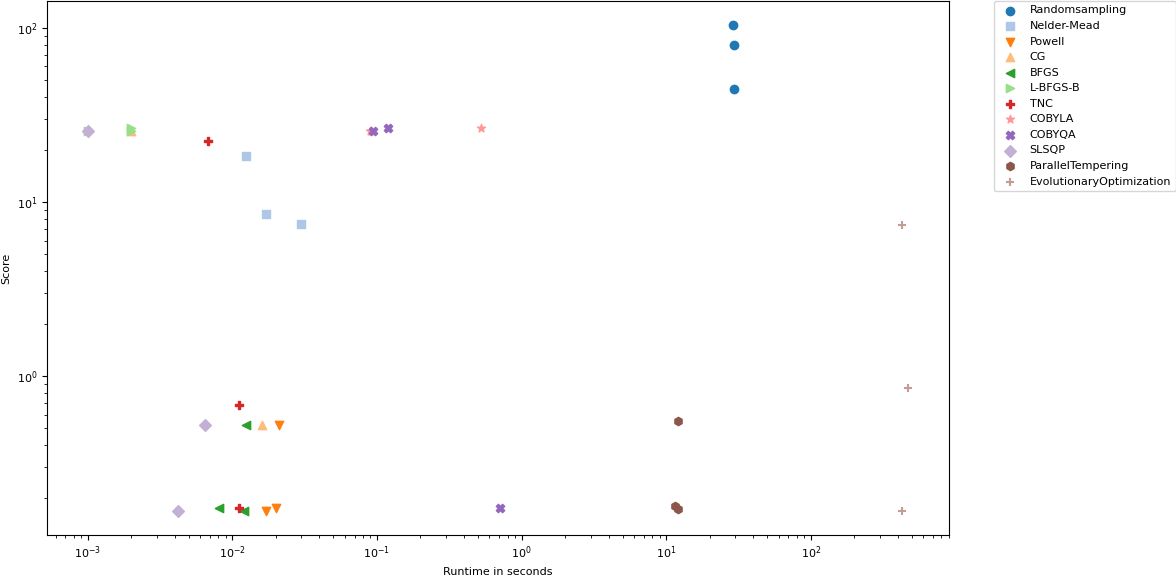

In [15]:

plt.figure(figsize=(12,6))
markers = ['o', 's', 'v', '^', '<', '>', 'P', '*', 'X', 'D', 'h', '+']
colors = plt.cm.tab20.colors  # Up to 20 distinct colors

for i, (key, value) in enumerate(algo_data.items()):
    run_label = f"{key}"

    run_time = []
    run_score = []
    for run in value:
        run_time.append(run[1])
        run_score.append(run[2])

    plt.scatter(run_time, run_score, label=run_label, color=colors[i % len(colors)], 
                marker=markers[i % len(markers)])


plt.xlabel("Runtime in seconds")
plt.ylabel("Score")
plt.xscale("log")
plt.yscale("log")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.          
)
plt.tight_layout()
plt.show()
